# Тестовое задание Data Science



![Снимок экрана 2025-08-27 в 16.42.39.png](https://voltaic-soldier-ed2.notion.site/image/attachment%3Ad9f64690-7779-4b1b-832e-8ac182a448b6%3A%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA_%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0_2025-08-27_%D0%B2_16.42.39.png?table=block&id=25ca79f6-0092-80f9-a864-c82dff963c87&spaceId=2f8a79f6-0092-8133-8dd4-0003a5a3688e&width=1420&userId=&cache=v2)

## Анонимизированные и преобразованные данные по заказам интернет-магазина

`df_train.csv` и `df_test.csv`.

Задача состоит в предсказании расходов за отказ от покупки конкретного товара (колонка `item_losses`).

Требуется продемонстрировать умение обрабатывать данные, создавать признаки для моделей, обучать и валидировать модели, писать качественный код.

Для файла `df_test.csv` также требуется предсказать целевую переменную (предсказание сохранить в колонке `y_pred` в `csv` файле с сохранением порядка строк как в `df_test.csv`).

Качество предсказаний будет проверяться на тестовых данных `df_test.csv` по метрике `RMSE`.

**Описание данных:**

`order_id` - id заказа

`departure_country` - id страны отправления заказа

`departure_city` - id города отправления заказа

`departure_region` - id региона города отправления заказа

`arrival_country` - id страны получения заказа

`arrival_city` - id города получения заказа

`arrival_region` - id региона города получения заказа

`order_date` - дата заказа

`stock_departure_date` - время отправки со склада

`delivery_service_departure_date` - время отправки службой доставки

`client_arrival_date` - время доставки заказа в пункт получения

`item_type` - тип товара (для кого предназначен)

`client_keywords` - запрос для перехода клиента

`client_device_type` - устройство клиента

`client_browser` - браузер клиента

`item_package_type` - способ упаковки

`client_is_app` - заказ из приложения

`order_tracking_available` - отслеживание заказа

`brand_name` - название бренда

`item_id` - id товара

`item_category` - категория товара

`delivery_service_name` - название службы доставки

`type_prepayment` - тип предоплаты

`item_price` - цена товара

`item_losses` - расходы за отказ от покупки (целевая переменная)

# Импорты

In [ ]:
# Установка всех нестандартных библиотек
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost catboost lightgbm category_encoders optuna plotly

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score

import optuna
from optuna.integration import OptunaSearchCV
import optuna.distributions as dist

from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.style.use('dark_background')

SEED = 1337

# Первичный осмотр данных

In [2]:
df_train = pd.read_csv("datasets/df_train.csv")
df_test = pd.read_csv("datasets/df_test.csv")

# Общая информация

def display_cols(df, n, k):
    for i in range(0, len(df.columns), n):
        display(df.iloc[:k, i:i+n])

print("TRAIN DATA INFO:")
df_train.info()
display_cols(df_train, 7, 2)

print("\nTEST DATA INFO:")
df_test.info()
display_cols(df_test, 7, 2)

TRAIN DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276205 entries, 0 to 276204
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       276205 non-null  int64  
 1   order_id                         276205 non-null  object 
 2   departure_country                276205 non-null  int64  
 3   departure_city                   269885 non-null  float64
 4   departure_region                 276205 non-null  int64  
 5   arrival_country                  276205 non-null  int64  
 6   arrival_city                     267342 non-null  float64
 7   arrival_region                   276205 non-null  int64  
 8   order_date                       276205 non-null  object 
 9   stock_departure_date             276205 non-null  object 
 10  delivery_service_departure_date  276205 non-null  object 
 11  client_arrival_date              276205 non-null

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city
0,0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0000,466,12,162.0000
1,1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0000,292,12,121.0000


,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords
0,888,2017-12-27 09:49:55,00-48-00 2018-01-02,12-04-00 2018-01-03,18-09-00 2018-01-03,0,"[326, 51, 37]"
1,351,2016-10-17 21:17:17,14-50-00 2016-11-02,21-33-00 2016-11-02,08-10-00 2016-11-03,0,[77]


,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id
0,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304
1,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6


,item_category,delivery_service_name,type_prepayment,item_price,item_losses
0,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.2282,0.0000
1,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.4820,0.0000



TEST DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77837 entries, 0 to 77836
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       77837 non-null  int64  
 1   order_id                         77837 non-null  object 
 2   departure_country                77837 non-null  int64  
 3   departure_city                   76090 non-null  float64
 4   departure_region                 77837 non-null  int64  
 5   arrival_country                  77837 non-null  int64  
 6   arrival_city                     75418 non-null  float64
 7   arrival_region                   77837 non-null  int64  
 8   order_date                       77837 non-null  object 
 9   stock_departure_date             77837 non-null  object 
 10  delivery_service_departure_date  77837 non-null  object 
 11  client_arrival_date              77837 non-null  object 
 12  i

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city
0,0,3c39f09f-1f30-4d48-afd8-7ac959d4f2f3,12,125.0000,824,12,121.0000
1,1,660eec62-8547-4e5c-9981-afd14f2466f4,12,642.0000,635,12,193.0000


,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords
0,1732,2018-05-15 14:41:20,19-35-00 2018-07-05,19-35-00 2018-07-05,23-33-00 2018-07-05,0,NaN
1,215,2018-05-08 14:22:07,03-32-00 2018-07-26,05-19-00 2018-07-28,03-01-00 2018-07-30,0,NaN


,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id
0,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],340bd249-e659-4257-a2a3-c1eb8271183e
1,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],85272285-4549-45be-a4f9-9e74687a21f5


,item_category,delivery_service_name,type_prepayment,item_price
0,5554bea4-f3cd-4432-bb13-73698f52de88,eec00286-b56b-44b0-8882-7b7022355a8f,0,630.3887
1,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,1,1436.8475


In [3]:
# Удалим технический столбец
df_train = df_train.drop(columns=["Unnamed: 0"])
df_test = df_test.drop(columns=["Unnamed: 0"])


--- Пропуски в train ---


,missing,%
client_keywords,214992,77.8400
arrival_city,8863,3.2100
departure_city,6320,2.2900
departure_region,0,0.0000
order_id,0,0.0000



--- Пропуски в test ---


,missing,%
client_keywords,63118,81.0900
arrival_city,2419,3.1100
departure_city,1747,2.2400
departure_country,0,0.0000
departure_region,0,0.0000



--- Уникальные значения ---


item_price                         270834
order_id                           193284
order_date                         192577
client_arrival_date                126786
delivery_service_departure_date    118719
stock_departure_date                99677
item_losses                         17908
client_keywords                      9012
item_id                              1866
arrival_region                       1395
departure_region                     1220
arrival_city                          671
departure_city                        587
client_device_type                    468
brand_name                            113
delivery_service_name                  25
arrival_country                        13
departure_country                      12
client_browser                          8
item_category                           6
item_package_type                       5
type_prepayment                         4
item_type                               3
client_is_app                     

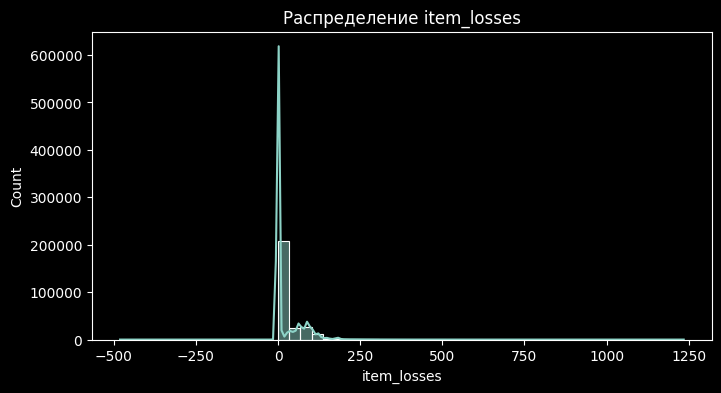

count   276205.0000
mean        23.5843
std         47.7635
min       -480.8484
25%          0.0000
50%          0.0000
75%         34.2092
max       1234.9547
Name: item_losses, dtype: float64

In [4]:
print("\n--- Пропуски в train ---")
display(
    df_train.isna()
    .sum()
    .to_frame("missing")
    .assign(**{"%": lambda x: (100 * x["missing"] / len(df_train)).round(2)})
    .sort_values("missing", ascending=False)
    .head(5)
)

print("\n--- Пропуски в test ---")
display(
    df_test.isna()
    .sum()
    .to_frame("missing")
    .assign(**{"%": lambda x: (100 * x["missing"] / len(df_test)).round(2)})
    .sort_values("missing", ascending=False)
    .head(5)
)

print("\n--- Уникальные значения ---")
unique_counts = df_train.nunique().sort_values(ascending=False)
display(unique_counts)

plt.figure(figsize=(8,4))
sns.histplot(df_train["item_losses"], bins=50, kde=True)
plt.title("Распределение item_losses")
plt.show()
display(df_train["item_losses"].describe())

In [5]:
zero_ratio = len(df_train[df_train['item_losses'] == 0]) / len(df_train) * 100
print(f"Доля нулей: {zero_ratio:.1f}%")

Доля нулей: 72.5%


In [6]:
has_keywords = df_train['client_keywords'].notna().astype(int)
y_is_zero = (df_train['item_losses'] == 0).astype(int)

ct = pd.crosstab(has_keywords, y_is_zero, normalize='index')
print(ct)

corr = np.corrcoef(has_keywords, y_is_zero)[0, 1]
print("коэффициент корреляции Пирсона между наличием ключей и нулевми расходами:", corr)


item_losses          0      1
client_keywords              
0               0.2776 0.7224
1               0.2653 0.7347
коэффициент корреляции Пирсона между наличием ключей и нулевми расходами: 0.011429884879715276


У тех, у кого нет ключевых слов (0), вероятность нулевых расходов ≈ 27.8%.
У тех, у кого есть ключевые слова (1), вероятность нулевых расходов ≈ 26.5%.
→ Разница очень маленькая, всего около 1%.

Корреляция Пирсона почти нулевая корреляция, линейной связи между наличием `client_keywords` и нулевыми расходами нет. 

Наличие `client_keywords` само по себе почти ничего не даёт для предсказания нулей. Но!

Может быть полезно не само наличие, а состав списка ([326, 51, 37] и т.д.).

Эти коды могут отражать категории запросов (например, "доставка", "возврат", "скидка"),  тогда отдельные токены могут иметь связь с расходами

In [7]:
all_tokens = set()
for kw in df_train["client_keywords"].dropna():
    tokens = [t.strip() for t in kw.strip("[] ").split(',') if t.strip()]
    all_tokens.update(tokens)

print(f"Уникальных токенов: {len(all_tokens)}")
print(sorted(list(all_tokens))[:5])

Уникальных токенов: 2557
['1', '10', '100', '1000', '1001']


2557 уникальных значений, закодировать OneHot энкодером будет не рационально. возможно лучше просто сделать эмбеддинг

In [8]:
max_tokens = df_train['client_keywords'].dropna().apply(lambda s: len(s.strip("[] ").split(","))).max()
print(f'Максимальная длинна списка ключевых слов: {max_tokens}')

Максимальная длинна списка ключевых слов: 18


### Пропуски

`client_keywords` - 214k пропусков (~78% в train, ~81% в test). Использовать как фичу нецелесообразно, лучше выкинуть или оставить только как индикатор «есть ли keywords» или сколько их

`arrival_city` и `departure_city` - пропусков меньше (2–3%). Можно кодировать NaN как отдельное значение

### Количественные признаки без изменений:

- `item_price`

- `order_tracking_available` - бинарный признак, кодировка не требуется, уже числовой тип данных

### обработка других признаков:

- `order_id` 193284 уникальных значений на трейне из 276205 записей. значительная часть записей принадлежат к одному заказу. из этого можно выделить признак количества товаров в заказе

- `client_keywords` - из этого сделаем признак количества ключевых слов в запросе из длинны списка в записи

- `departure_country`, `departure_city`, `departure_region`, `arrival_country`, `arrival_city`, `arrival_region` - из этих индексов можно сделать признаки того, является ли это доставкой в другую страну/регион/город

- `order_date`, `client_arrival_date`, `delivery_service_departure_date`, `stock_departure_date` - из этих признаков получить дельты времени между датой заказа и временем отправки со склада, временем отправки со склада и временем отправки службой доставки, временем отправки службой доставки и временем доставки заказа в пункт получения и общем временем от заказа до получения

- `delivery_service_name` (25), `client_browser` (8), `item_category` (6), `item_package_type` (5), `type_prepayment` (4), `item_type` (3) - нормальная кардинальность можно категориального признака:  можно закодировать с помощью one-hot энкодера

- `item_id` (1866), `client_device_type` (468), `brand_name` (113) - Высокая кардинальность категориального признака: нужно аккуратное кодирование

- `client_is_app` - нужно перевести из булева в числовой тип данных


## прочие замечания

- Большинство заказов без убытков (медиана = 0)

- У части заказов есть отрицательные значения убытков (min = -480), это выглядит подозрительно (ошибки в данных?). Нужно разобратся

# Избавление от пропусков и Аномалий

In [9]:
df_train[(df_train['item_losses'] < 0)]

,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
60664,c290ce6a-acac-40cb-aaea-77ef3be79a67,12,556.0000,1443,12,68.0000,1274,2017-06-01 18:26:28,21-10-00 2017-07-24,21-10-00 2017-07-24,23-06-00 2017-07-25,0,NaN,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],fe1c74ac-e22d-445f-a1cd-6ea30fc85957,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,963.3772,-310.1238
87169,be4127b1-38e3-401d-8548-79f6b34c2cb2,12,125.0000,824,12,276.0000,1253,2017-06-28 02:45:39,21-02-00 2017-08-25,21-02-00 2017-08-25,10-46-00 2017-08-27,0,NaN,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,False,0,"['fe714603-2276-40f8-b021-ca9d205c8e41', '1f56...",3da7a462-538e-42bf-b4b6-6709d6afce7f,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,2125.0411,-23.7847
127727,c290ce6a-acac-40cb-aaea-77ef3be79a67,12,556.0000,1443,12,68.0000,1274,2017-06-01 18:26:28,21-10-00 2017-07-24,21-10-00 2017-07-24,23-06-00 2017-07-25,0,NaN,2,1,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0,[],fe1c74ac-e22d-445f-a1cd-6ea30fc85957,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,698.2872,-480.8484
275205,be4127b1-38e3-401d-8548-79f6b34c2cb2,12,125.0000,824,12,276.0000,1253,2017-06-28 02:45:39,21-02-00 2017-08-25,21-02-00 2017-08-25,10-46-00 2017-08-27,0,NaN,1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,False,0,"['fe714603-2276-40f8-b021-ca9d205c8e41', '1f56...",3da7a462-538e-42bf-b4b6-6709d6afce7f,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,2125.2750,-23.7847


In [10]:
# удалим эти 4 аномальные строки
df_train = df_train[~(df_train['item_losses'] < 0)]

Обработку пропусков учтём в рамках пайплайна предобработки

In [25]:
# Классы для препроцессинга в рамках пайплайна

class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Извлекает временные признаки и вычисляет дельты времени этапов доставки до клиента
    Дли инициализации нужен список 4 колонок в порядке от заказа до получения
    """
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X[self.col[0]] = pd.to_datetime(X[self.col[0]], errors="coerce")
        for i in range(1,4):
            X[self.col[i]] = pd.to_datetime(X[self.col[i]],
            format="%H-%M-%S %Y-%m-%d", errors="coerce")
        
        # Создание временных дельт (в часах)
        if all(c in X.columns for c in self.col):
            for i in range(3):
                X[f'delivery_{i+1}'] = (
                    X[self.col[i+1]] - X[self.col[i]]
                ).dt.total_seconds() / 3600

            X['delivery_full'] = (
                X[self.col[3]] - X[self.col[0]]
            ).dt.total_seconds() / 3600
        
        if 'item_price' in X.columns and 'delivery_full' in X.columns:
            X['price_per_hour'] = X['item_price'] / (X['delivery_full'] + 1)

        if all(col in X.columns for col in ['delivery_1', 'delivery_2', 'delivery_3']):
            X['delivery_speed'] = X['delivery_1'] / (X['delivery_2'] + X['delivery_3'] + 1) # соотношение "подготовки" к "транспортировке"
            X['total_transport_time'] = X['delivery_2'] + X['delivery_3']  # только транспорт
            X['prep_vs_transport'] = X['delivery_1'] / (X['total_transport_time'] + 1)

                
        # Извлечение признаков из даты заказа
        if self.col[0] in X.columns:
            X['order_hour'] = X[self.col[0]].dt.hour
            X['order_day_of_week'] = X[self.col[0]].dt.dayofweek
            X['order_month'] = X[self.col[0]].dt.month
            X['order_day_of_month'] = X[self.col[0]].dt.day
            X['is_weekend'] = (X[self.col[0]].dt.dayofweek >= 5).astype(int)
        
            # Час (24-часовой цикл)
            X['order_hour_sin'] = np.sin(2 * np.pi * X['order_hour'] / 24)
            X['order_hour_cos'] = np.cos(2 * np.pi * X['order_hour'] / 24)
            
            # День недели (7-дневный цикл)
            X['order_day_of_week_sin'] = np.sin(2 * np.pi * X['order_day_of_week'] / 7)
            X['order_day_of_week_cos'] = np.cos(2 * np.pi * X['order_day_of_week'] / 7)
            
            # Месяц (12-месячный цикл)
            X['order_month_sin'] = np.sin(2 * np.pi * X['order_month'] / 12)
            X['order_month_cos'] = np.cos(2 * np.pi * X['order_month'] / 12)
            
            # День месяца (31-дневный цикл, но это спорно)
            X['order_day_of_month_sin'] = np.sin(2 * np.pi * X['order_day_of_month'] / 31)
            X['order_day_of_month_cos'] = np.cos(2 * np.pi * X['order_day_of_month'] / 31)
        
        # Удаляем исходные колонки с датами (они больше не нужны)
        X = X.drop(columns=self.col, errors='ignore')
        
        return X

class GeographicFeatureExtractor(BaseEstimator, TransformerMixin):
    """Создает географические бинарные признаки: 
    - международная посылка;
    - в другой регион; 
    - межгород
    - данные о городе отсутствуют
    """

    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if all(c in X.columns for c in self.col):
            X['is_international_delivery'] = (
                (X[self.col[0]].notna()) & (X[self.col[1]].notna()) &
                (X[self.col[0]].notna()) & (X[self.col[1]].notna())
                ).astype(int)
            X['is_interregional_delivery'] = (
                (X[self.col[2]].notna()) & (X[self.col[3]].notna()) &
                (X[self.col[2]].notna()) & (X[self.col[3]].notna())
                ).astype(int)
            X['is_intercity_delivery'] = (
                (X[self.col[4]].notna()) & (X[self.col[5]].notna()) &
                (X[self.col[4]].notna()) & (X[self.col[5]].notna())
                ).astype(int)
            X['missing_city_info'] = (X[self.col[4]].isna() | X[self.col[5]].isna()).astype(int)    
            
        # Дропаем колонки городов, они больше не нужны
        X = X.drop(columns=self.col, errors='ignore')
        
        return X

class OrderFeatureExtractor(BaseEstimator, TransformerMixin):
    """Извлекает признак количества позиций в заказе"""
    
    def __init__(self, col):
        self.order_counts = {}
        self.col = col
    
    def fit(self, X, y=None):
        # Сохраняем маппинг количества товаров в заказе
        if self.col in X.columns:
            self.order_counts = X[self.col].value_counts().to_dict()
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Количество товаров в заказе
        if self.col in X.columns:
            X['items_per_order'] = X[self.col].map(self.order_counts).fillna(1)
            
        # Дропаем order_id, он больше не нужен
        X = X.drop(columns=[self.col], errors='ignore')
        
        return X

class KeywordsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Извлекает признаки из client_keywords через TF-IDF + SVD"""

    def __init__(self, col, n_components=36):
        self.col = col
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(token_pattern=r"\d+")
        self.svd = None

    def preprocess(self, keywords):
        if pd.isna(keywords):
            return ""
        return keywords.strip("[] ").replace(" ", "")

    def fit(self, X, y=None):
        texts = X[self.col].fillna("").apply(self.preprocess)
        X_tfidf = self.vectorizer.fit_transform(texts)
        n_comp = min(self.n_components, X_tfidf.shape[1])
        self.svd = TruncatedSVD(n_components=n_comp, random_state=SEED)
        self.svd.fit(X_tfidf)
        return self

    def transform(self, X):
        X_copy = X.copy()
        texts = X_copy[self.col].fillna("").apply(self.preprocess)
        X_tfidf = self.vectorizer.transform(texts)
        X_svd = self.svd.transform(X_tfidf)
        n_svd_features = X_svd.shape[1]

        for i in range(n_svd_features):
            X_copy[f"kw_emb_{i}"] = X_svd[:, i]

        X_copy = X_copy.drop(columns=[self.col])
        return X_copy

class BoolToNumTransformer(BaseEstimator, TransformerMixin):
    """преобразыет булевы значения False/True в числовые 0/1"""

    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for c in self.col:
            if c in X.columns:
                X[c] = X[c].astype(int)
        
        return X

# Подготовка к обучению

Так как в датасете очень большой дисбаланс в сторону нулевых расходов (72.5%), то принято решение использовать Zero-Inflated подход, сначала предсказываем моделью классификации будут ли расходы вообще, а потом регрессией определяем количество расходов если они есть.


In [ ]:
# подготовка класса для Zero-Inflated модели

class ZeroInflatedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, classifier, regressor, threshold=0.5, use_log_transform=True):
        self.classifier = classifier
        self.regressor = regressor
        self.threshold = threshold
        self.use_log_transform = use_log_transform

    def fit(self, X, y):
        y_bin = (y > 0).astype(int)

        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X, y_bin)

        mask = y > 0
        if np.any(mask):
            y_reg = y[mask]
            if self.use_log_transform:
                y_reg = np.log1p(y_reg)
            
            self.regressor_ = clone(self.regressor)
            self.regressor_.fit(X[mask], y_reg)

        return self

    def predict(self, X):
        prob_nonzero = self.classifier_.predict_proba(X)[:, 1]
        is_nonzero = prob_nonzero >= self.threshold

        y_pred = np.zeros(len(X))
        if np.any(is_nonzero):
            y_pred_reg = self.regressor_.predict(X[is_nonzero])
            
            if self.use_log_transform:
                y_pred_reg = np.expm1(y_pred_reg)
            
            y_pred[is_nonzero] = np.clip(y_pred_reg, 0, None)
        
        return y_pred

In [13]:
# Разделение фичей и таргета
X_train = df_train.drop(['item_losses'], axis=1)
y_train = df_train['item_losses']

In [26]:
# Формируем препроцессор для подготовки фичей
categorial_fetures = [
    'item_id', 'client_device_type', 'brand_name',
    'delivery_service_name', 'client_browser', 'item_category',
    'item_package_type', 'type_prepayment', 'item_type'
    ]

preprocessor = Pipeline([
    ('date_features', DateFeatureExtractor(['order_date', 'stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date'])),
    ('geographic_features', GeographicFeatureExtractor(['departure_country', 'arrival_country', 'departure_region', 'arrival_region', 'departure_city', 'arrival_city'])),
    ('order_features', OrderFeatureExtractor('order_id')),
    ('keywords_features', KeywordsFeatureExtractor('client_keywords')),
    ('bool_to_num', BoolToNumTransformer(['client_is_app'])),
    ('categorical_encoder', TargetEncoder(cols=categorial_fetures))
])

In [27]:
# протестируем работу препроцессора
test_pipeline = Pipeline([('preprocessor', preprocessor)])
test_X = test_pipeline.fit_transform(X_train, y_train)

test_X.info()
display_cols(test_X, 6, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 276201 entries, 0 to 276204
Data columns (total 74 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_type                  276201 non-null  float64
 1   client_device_type         276201 non-null  float64
 2   client_browser             276201 non-null  float64
 3   item_package_type          276201 non-null  float64
 4   client_is_app              276201 non-null  int64  
 5   order_tracking_available   276201 non-null  int64  
 6   brand_name                 276201 non-null  float64
 7   item_id                    276201 non-null  float64
 8   item_category              276201 non-null  float64
 9   delivery_service_name      276201 non-null  float64
 10  type_prepayment            276201 non-null  float64
 11  item_price                 276201 non-null  float64
 12  delivery_1                 276201 non-null  float64
 13  delivery_2                 276201 

,item_type,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available
0,24.6586,22.4445,24.7658,24.5270,1,0
1,24.6586,22.8798,22.5509,24.5270,1,0


,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price
0,22.8566,14.9792,27.3573,21.7231,20.6442,443.2282
1,33.9371,32.9482,27.3573,22.8637,23.7205,589.4820


,delivery_1,delivery_2,delivery_3,delivery_full,price_per_hour,delivery_speed
0,134.9681,35.2667,6.0833,176.3181,2.4996,3.1870
1,377.5453,6.7167,10.6167,394.8786,1.4890,20.5934


,total_transport_time,prep_vs_transport,order_hour,order_day_of_week,order_month,order_day_of_month
0,41.3500,3.1870,9,2,12,27
1,17.3333,20.5934,21,0,10,17


,is_weekend,order_hour_sin,order_hour_cos,order_day_of_week_sin,order_day_of_week_cos,order_month_sin
0,0,0.7071,-0.7071,0.9749,-0.2225,-0.0000
1,0,-0.7071,0.7071,0.0000,1.0000,-0.8660


,order_month_cos,order_day_of_month_sin,order_day_of_month_cos,is_international_delivery,is_interregional_delivery,is_intercity_delivery
0,1.0000,-0.7248,0.6890,1,1,1
1,0.5000,-0.2994,-0.9541,1,1,1


,missing_city_info,items_per_order,kw_emb_0,kw_emb_1,kw_emb_2,kw_emb_3
0,0,6,0.0021,-0.0084,-0.0023,0.0036
1,0,2,-0.0000,-0.0000,0.0000,-0.0000


,kw_emb_4,kw_emb_5,kw_emb_6,kw_emb_7,kw_emb_8,kw_emb_9
0,-0.0038,-0.0075,0.0391,0.0092,-0.0193,-0.0117
1,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000


,kw_emb_10,kw_emb_11,kw_emb_12,kw_emb_13,kw_emb_14,kw_emb_15
0,-0.0420,-0.0135,-0.0163,-0.0000,-0.0092,0.0056
1,0.0000,0.0000,-0.0000,1.0000,-0.0000,-0.0000


,kw_emb_16,kw_emb_17,kw_emb_18,kw_emb_19,kw_emb_20,kw_emb_21
0,0.0321,0.1259,0.0251,-0.0000,-0.0005,0.0417
1,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000


,kw_emb_22,kw_emb_23,kw_emb_24,kw_emb_25,kw_emb_26,kw_emb_27
0,0.0658,-0.1515,0.1104,-0.0545,0.7067,0.0448
1,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000


,kw_emb_28,kw_emb_29,kw_emb_30,kw_emb_31,kw_emb_32,kw_emb_33
0,0.0067,-0.0361,0.0860,-0.0006,0.0657,-0.0191
1,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000


,kw_emb_34,kw_emb_35
0,-0.0244,0.0457
1,0.0000,0.0000


Проблем в работе препроцессора не обнаружено, приступаем к обучению модели

In [16]:
# подсчет нулевых и ненулевых строк для балансировки классов
y_bin = (y_train > 0).astype(int)
n_zeros = (y_bin == 0).sum()
n_nonzeros = (y_bin == 1).sum()

In [17]:
# создаём объект для кросс валидации
cv = KFold(n_splits=3, random_state=SEED, shuffle=True)

In [ ]:
# Инструменты для оценки и сравнения качества найденных параметров
results = pd.DataFrame(columns=['Model', 'RMSE'])
best_params = {}

def analyze_optuna_results(optuna_obj, full_model_name, n, results, best_params, show_plots=True, show_top_trials=5):
    """
    Полный анализ результатов Optuna с графиками и сохранением в таблицы
    
    Parameters:
    -----------
    optuna_obj : OptunaSearchCV Объект с результатами оптимизации
    full_model_name : str Название модели для отображения
    n : int Индекс для сохранения в таблицу results
    results : pd.DataFrame Таблица для сохранения результатов
    best_params : dict Словарь для сохранения лучших параметров
    show_plots : bool Показывать ли графики
    show_top_trials : int Количество лучших trials для отображения
    """
    
    mean_test_rmse = optuna_obj.cv_results_['mean_test_score']
    std_test_rmse = optuna_obj.cv_results_['std_test_score']
    best_rmse = -mean_test_rmse[optuna_obj.best_index_]
    best_std = std_test_rmse[optuna_obj.best_index_]
    best_params_dict = optuna_obj.best_params_
    study = optuna_obj.study_ if hasattr(optuna_obj, 'study_') else None


    print("=" * 80)
    print(f"🎯 {full_model_name}")
    print("=" * 80)
    print(f"✅ Лучшие параметры: {best_params_dict}")
    print("-" * 80)
    print(f"📊 Наилучший RMSE на кросс-валидации: {best_rmse:.4f}")
    
    if best_std is not None:
        print(f"📈 Стандартное отклонение: ±{best_std:.4f}")
        print(f"🎯 95% доверительный интервал: [{best_rmse - 1.96*best_std:.4f}, {best_rmse + 1.96*best_std:.4f}]")
    
    if study is not None:
        completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]
        pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
        
        print(f"🔄 Общее количество trials: {len(study.trials)}")
        print(f"✅ Успешных: {len(completed_trials)}")
        print(f"❌ Неудачных: {len(failed_trials)}")
        print(f"✂️  Обрезанных (pruned): {len(pruned_trials)}")
        
        if len(completed_trials) > 0:
            trial_values = [-t.value for t in completed_trials]
            print(f"📊 Среднее RMSE: {np.mean(trial_values):.4f}")
            print(f"📊 Медианное RMSE: {np.median(trial_values):.4f}")
            print(f"📊 Стандартное отклонение RMSE: {np.std(trial_values):.4f}")
        
        if len(completed_trials) >= show_top_trials:
            print(f"\n🏆 Топ-{show_top_trials} результатов:")
            top_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)[:show_top_trials]
            for i, trial in enumerate(top_trials):
                print(f"   {i+1}. RMSE: {-trial.value:.4f} (trial #{trial.number})")
    
    print("=" * 80)
    
    if show_plots and study is not None:
        try:
            pio.templates.default = "plotly_white"
            
            completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
            
            if len(completed_trials) > 0:
                print("📈 Строим графики...")
                
                trial_numbers = [t.number for t in completed_trials]
                trial_values = [-t.value for t in completed_trials]
                
                best_so_far = []
                current_best = float('inf')
                for val in trial_values:
                    if val < current_best:
                        current_best = val
                    best_so_far.append(current_best)
                
                fig = make_subplots(
                    rows=2, cols=2,
                    subplot_titles=(
                        'История оптимизации', 
                        'Распределение RMSE',
                        'Важность параметров',
                        'Прогресс лучших результатов'
                    ),
                    specs=[[{"secondary_y": False}, {"secondary_y": False}],
                           [{"secondary_y": False}, {"secondary_y": False}]]
                )
                
                fig.add_trace(
                    go.Scatter(
                        x=trial_numbers, y=trial_values,
                        mode='markers',
                        name='Trial RMSE',
                        opacity=0.6,
                        marker=dict(
                            color=trial_values,
                            colorscale='RdYlBu_r',
                            showscale=True,
                            colorbar=dict(title="RMSE", x=0.45)
                        )
                    ),
                    row=1, col=1
                )
                
                fig.add_trace(
                    go.Scatter(
                        x=trial_numbers, y=best_so_far,
                        mode='lines',
                        name='Лучший RMSE',
                        line=dict(color='red', width=3)
                    ),
                    row=1, col=1
                )
                
                fig.add_trace(
                    go.Histogram(
                        x=trial_values,
                        nbinsx=20,
                        name='Распределение RMSE',
                        opacity=0.7,
                        marker_color='lightblue'
                    ),
                    row=1, col=2
                )
                
                try:
                    param_importance = optuna.importance.get_param_importances(study)
                    if param_importance:
                        param_names = list(param_importance.keys())
                        param_values = list(param_importance.values())
                        
                        short_names = [name.replace('model__', '').replace('regressor__', 'reg_').replace('classifier__', 'cls_') 
                                     for name in param_names]
                        
                        fig.add_trace(
                            go.Bar(
                                x=param_values,
                                y=short_names,
                                orientation='h',
                                name='Важность',
                                marker_color='lightgreen'
                            ),
                            row=2, col=1
                        )
                except:
                    print("⚠️ Не удалось построить график важности параметров")
                
                if len(trial_values) > 5:
                    window_size = min(10, len(trial_values) // 5)
                    rolling_mean = pd.Series(trial_values).rolling(window=window_size).mean()
                    
                    fig.add_trace(
                        go.Scatter(
                            x=trial_numbers,
                            y=rolling_mean,
                            mode='lines',
                            name=f'Скользящее среднее ({window_size})',
                            line=dict(color='orange', width=2)
                        ),
                        row=2, col=2
                    )
                
                fig.update_layout(
                    title=f"Анализ оптимизации: {full_model_name}",
                    height=800,
                    showlegend=True,
                    title_font_size=16
                )
                
                fig.update_xaxes(title_text="Номер Trial", row=1, col=1)
                fig.update_yaxes(title_text="RMSE", row=1, col=1)
                fig.update_xaxes(title_text="RMSE", row=1, col=2)
                fig.update_yaxes(title_text="Частота", row=1, col=2)
                fig.update_xaxes(title_text="Важность", row=2, col=1)
                fig.update_yaxes(title_text="Параметры", row=2, col=1)
                fig.update_xaxes(title_text="Номер Trial", row=2, col=2)
                fig.update_yaxes(title_text="RMSE (скользящее среднее)", row=2, col=2)
                fig.show()
                

                if len(param_importance) > 2:
                    try:
                        print("📊 График параллельных координат...")
                        parallel_fig = optuna.visualization.plot_parallel_coordinate(
                            study, 
                            params=list(param_importance.keys())[:8]
                        )
                        parallel_fig.update_layout(title=f"Параллельные координаты: {full_model_name}")
                        parallel_fig.show()
                    except:
                        print("⚠️ Не удалось построить график параллельных координат")
                
        except ImportError:
            print("⚠️ Для красивых графиков установите: pip install plotly")
            print("   Или используйте show_plots=False")
            
            try:
                completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
                trial_values = [-t.value for t in completed_trials]
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.plot(trial_values, 'b-o', alpha=0.6, markersize=3)
                plt.title('История оптимизации')
                plt.xlabel('Trial')
                plt.ylabel('RMSE')
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 2, 2)
                plt.hist(trial_values, bins=20, alpha=0.7, color='lightblue')
                plt.title('Распределение RMSE')
                plt.xlabel('RMSE')
                plt.ylabel('Частота')
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
            except ImportError:
                print("⚠️ Matplotlib также недоступен. Графики пропущены.")
    
    print("💾 Сохраняем результаты...")
    results.loc[n] = [full_model_name, best_rmse]
    best_params[full_model_name] = best_params_dict
    print(f"✅ Результаты сохранены: {full_model_name} -> RMSE: {best_rmse:.4f}")
    print("=" * 80)
    print()

# Обучение моделей

## LinearRegression model

In [19]:
lin_model = LinearRegression()

lin_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lin_model)
])

lin_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date_features',
                                  DateFeatureExtractor(col=['order_date',
                                                            'stock_departure_date',
                                                            'delivery_service_departure_date',
                                                            'client_arrival_date'])),
                                 ('geographic_features',
                                  GeographicFeatureExtractor(col=['departure_country',
                                                                  'arrival_country',
                                                                  'departure_region',
                                                                  'arrival_region',
                                                                  'departure_city',
                                                                  'arrival_city'])),...
                                 ('keywords_features',
                                  KeywordsFeatureExtractor(col='client_keywords')),
                                 ('bool_to_num',
                                  BoolToNumTransformer(col=['client_is_app'])),
                                 ('categorical_encoder',
                                  TargetEncoder(cols=['item_id',
                                                      'client_device_type',
                                                      'brand_name',
                                                      'delivery_service_name',
                                                      'client_browser',
                                                      'item_category',
                                                      'item_package_type',
                                                      'type_prepayment',
                                                      'item_type']))])),
                ('model', LinearRegression())])

In [20]:
lin_rmse = -cross_val_score(lin_pipeline, X_train, y_train,
                            cv=cv, scoring='neg_root_mean_squared_error').mean()

results.loc[0] = ['LinearRegression', lin_rmse]
best_params['LinearRegression'] = {}
print("LinearRegression")
print("~" * 79)
print("Средний RMSE на кросс-валидации:", round(lin_rmse, 4))

LinearRegression
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Средний RMSE на кросс-валидации: 46.4277


## XG Boost model

In [ ]:
xgb_optuna_params = {
    'preprocessor__keywords_features__n_components': dist.IntDistribution(36, 72, step=18),
    
    'model__threshold': dist.FloatDistribution(0.4, 0.8, step=0.01),
    
    'model__classifier__n_estimators': dist.IntDistribution(800, 1200, step=100),
    'model__classifier__max_depth': dist.IntDistribution(8, 16, step=1),
    'model__classifier__learning_rate': dist.FloatDistribution(0.1, 0.2, step=0.01),
    
    'model__regressor__n_estimators': dist.IntDistribution(600, 1000, step=100),
    'model__regressor__max_depth': dist.IntDistribution(6, 12, step=1),
    'model__regressor__learning_rate': dist.FloatDistribution(0.1, 0.2, step=0.01),
    'model__regressor__subsample': dist.FloatDistribution(0.8, 1.0, step=0.1),
    'model__regressor__colsample_bytree': dist.FloatDistribution(0.6, 1.0, step=0.1),
}

xgb_cls_model = XGBClassifier(
    random_state=SEED,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    scale_pos_weight=(n_zeros / n_nonzeros),
    n_jobs=1
)

xgb_reg_model = XGBRegressor(
    random_state=SEED,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_jobs=1
)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ZeroInflatedRegressor(xgb_cls_model, xgb_reg_model))
])

xgb_optuna = OptunaSearchCV(
    xgb_pipeline,
    xgb_optuna_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=3600,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

xgb_optuna.fit(X_train, y_train)
best_xgb_model = xgb_optuna.best_estimator_

In [ ]:
analyze_optuna_results(
    xgb_optuna, 
    'XGBoost', 
    1, 
    results, 
    best_params,
    show_plots=True,
    show_top_trials=5
)

🎯 XGBoost
✅ Лучшие параметры: {'preprocessor__keywords_features__n_components': 36, 'model__threshold': 0.71, 'model__classifier__n_estimators': 900, 'model__classifier__max_depth': 16, 'model__classifier__learning_rate': 0.13, 'model__regressor__n_estimators': 700, 'model__regressor__max_depth': 12, 'model__regressor__learning_rate': 0.16, 'model__regressor__subsample': 0.8, 'model__regressor__colsample_bytree': 1.0}
--------------------------------------------------------------------------------
📊 Наилучший RMSE на кросс-валидации: 40.7255
📈 Стандартное отклонение: ±0.0701
🎯 95% доверительный интервал: [40.5880, 40.8629]
🔄 Общее количество trials: 19
✅ Успешных: 19
❌ Неудачных: 0
✂️  Обрезанных (pruned): 0
📊 Среднее RMSE: 41.4906
📊 Медианное RMSE: 40.9624
📊 Стандартное отклонение RMSE: 1.3563

🏆 Топ-5 результатов:
   1. RMSE: 40.7255 (trial #11)
   2. RMSE: 40.7381 (trial #8)
   3. RMSE: 40.7690 (trial #12)
   4. RMSE: 40.7812 (trial #7)
   5. RMSE: 40.8249 (trial #14)
📈 Строим графи

📊 График параллельных координат...


💾 Сохраняем результаты...
✅ Результаты сохранены: XGBoost -> RMSE: 40.7255



![xgb1](images/xgb1.png)
![xgb2](images/xgb2.png)

## Catboost model

In [ ]:
cat_optuna_params = {
    'preprocessor__keywords_features__n_components': dist.IntDistribution(36, 72, step=18),
    
    'model__threshold': dist.FloatDistribution(0.4, 0.8, step=0.01),
    
    'model__classifier__iterations': dist.IntDistribution(800, 1000, step=100),
    'model__classifier__depth': dist.IntDistribution(4, 12, step=1),
    'model__classifier__learning_rate': dist.FloatDistribution(0.01, 0.2, step=0.01),
    'model__classifier__l2_leaf_reg': dist.FloatDistribution(0.5, 20, log=True),
    
    'model__regressor__iterations': dist.IntDistribution(600, 1000, step=100),
    'model__regressor__depth': dist.IntDistribution(4, 12, step=1),
    'model__regressor__learning_rate': dist.FloatDistribution(0.01, 0.2, step=0.01),
    'model__regressor__l2_leaf_reg': dist.FloatDistribution(0.5, 20, log=True),
}

cat_cls_model = CatBoostClassifier(
    random_seed=SEED,
    task_type="GPU",
    verbose=False,
    auto_class_weights='Balanced',
)

cat_reg_model = CatBoostRegressor(
    random_seed=SEED,
    task_type="GPU",
    verbose=False,
)

cat_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ZeroInflatedRegressor(cat_cls_model, cat_reg_model))
])

cat_optuna = OptunaSearchCV(
    cat_pipeline,
    cat_optuna_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=3600,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

cat_optuna.fit(X_train, y_train)
best_cat_model = cat_optuna.best_estimator_

In [23]:
analyze_optuna_results(
    cat_optuna, 
    'CatBoost', 
    2,
    results, 
    best_params,
    show_plots=True,
    show_top_trials=5
)

🎯 CatBoost
✅ Лучшие параметры: {'preprocessor__keywords_features__n_components': 36, 'model__threshold': 0.55, 'model__classifier__iterations': 1000, 'model__classifier__depth': 12, 'model__classifier__learning_rate': 0.06999999999999999, 'model__classifier__l2_leaf_reg': 0.5224269764458747, 'model__regressor__iterations': 1000, 'model__regressor__depth': 9, 'model__regressor__learning_rate': 0.2, 'model__regressor__l2_leaf_reg': 17.321663749188435}
--------------------------------------------------------------------------------
📊 Наилучший RMSE на кросс-валидации: 41.6007
📈 Стандартное отклонение: ±0.1325
🎯 95% доверительный интервал: [41.3411, 41.8604]
🔄 Общее количество trials: 21
✅ Успешных: 21
❌ Неудачных: 0
✂️  Обрезанных (pruned): 0
📊 Среднее RMSE: 47.3379
📊 Медианное RMSE: 47.4076
📊 Стандартное отклонение RMSE: 4.8447

🏆 Топ-5 результатов:
   1. RMSE: 41.6007 (trial #10)
   2. RMSE: 41.6069 (trial #11)
   3. RMSE: 42.1351 (trial #7)
   4. RMSE: 42.5117 (trial #20)
   5. RMSE: 4

📊 График параллельных координат...


💾 Сохраняем результаты...
✅ Результаты сохранены: CatBoost -> RMSE: 41.6007



![catboost1](images/catboost1.png)
![catboost2](images/catboost2.png)

## LihgtGBM model

In [ ]:
lgbm_optuna_params = {
    'model__threshold': dist.FloatDistribution(0.4, 0.8, step=0.01),

    'model__classifier__n_estimators': dist.IntDistribution(600, 1200, step=100),
    'model__classifier__max_depth': dist.IntDistribution(6, 20, step=1),
    'model__classifier__learning_rate': dist.FloatDistribution(0.01, 0.2, step=0.01),
    'model__classifier__num_leaves': dist.IntDistribution(20, 100, step=20),

    'model__regressor__n_estimators': dist.IntDistribution(600, 1200, step=100),
    'model__regressor__max_depth': dist.IntDistribution(6, 20, step=1),
    'model__regressor__learning_rate': dist.FloatDistribution(0.01, 0.2, step=0.01),
    'model__regressor__num_leaves': dist.IntDistribution(20, 100, step=20),
}

lgbm_cls_model = LGBMClassifier(
    random_state=SEED,
    device='gpu',
    class_weight='balanced',
    verbose=-1,
    n_jobs=1
)

lgbm_reg_model = LGBMRegressor(
    random_state=SEED,
    device='gpu',
    verbose=-1,
    n_jobs=1
)

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ZeroInflatedRegressor(lgbm_cls_model, lgbm_reg_model))
])

lgbm_optuna = OptunaSearchCV(
    lgbm_pipeline,
    lgbm_optuna_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=3600,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

lgbm_optuna.fit(X_train, y_train)
best_lgbm_model = lgbm_optuna.best_estimator_

[I 2025-09-26 00:05:10,747] A new study created in memory with name: no-name-b63ca95f-9d1a-4168-84a2-30272005f031
[I 2025-09-26 00:09:16,062] Trial 0 finished with value: -43.48391369181602 and parameters: {'model__threshold': 0.5700000000000001, 'model__classifier__n_estimators': 1000, 'model__classifier__max_depth': 17, 'model__classifier__learning_rate': 0.13, 'model__classifier__num_leaves': 100, 'model__regressor__n_estimators': 600, 'model__regressor__max_depth': 6, 'model__regressor__learning_rate': 0.17, 'model__regressor__num_leaves': 40}. Best is trial 0 with value: -43.48391369181602.


In [ ]:
analyze_optuna_results(
    lgbm_optuna, 
    'LightGBM', 
    3,
    results, 
    best_params,
    show_plots=True,
    show_top_trials=5
)

🎯 LightGBM
✅ Лучшие параметры: {'model__threshold': 0.62, 'model__classifier__n_estimators': 1000, 'model__classifier__max_depth': 15, 'model__classifier__learning_rate': 0.2, 'model__classifier__num_leaves': 100, 'model__regressor__n_estimators': 700, 'model__regressor__max_depth': 17, 'model__regressor__learning_rate': 0.2, 'model__regressor__num_leaves': 40}
--------------------------------------------------------------------------------
📊 Наилучший RMSE на кросс-валидации: 42.4322
📈 Стандартное отклонение: ±0.0841
🎯 95% доверительный интервал: [42.2673, 42.5971]
🔄 Общее количество trials: 16
✅ Успешных: 16
❌ Неудачных: 0
✂️  Обрезанных (pruned): 0
📊 Среднее RMSE: 47.4736
📊 Медианное RMSE: 46.0361
📊 Стандартное отклонение RMSE: 4.7775

🏆 Топ-5 результатов:
   1. RMSE: 42.4322 (trial #12)
   2. RMSE: 42.9028 (trial #6)
   3. RMSE: 43.0809 (trial #14)
   4. RMSE: 43.1664 (trial #11)
   5. RMSE: 43.4702 (trial #0)
📈 Строим графики...


📊 График параллельных координат...


💾 Сохраняем результаты...
✅ Результаты сохранены: LightGBM -> RMSE: 42.4322



![lgbm1](images/lgbm1.png)
![lgbm2](images/lgbm2.png)

Все три ZeroInflated модели показывают что самые важные параметры, влияющие не результат, это параметры модели классификатора.

Видимо классификатор является слабым звеном в этом пайплайне. В теории подход отсеить товары без трат на возврат хорош, но возможно на практике это либо не на много лучше чем линейная регрессия, либо нужно разделить подбор параметров для классификатора и лишь потом, найдя оптимальный по качество вариант классиыикатора искать решение для регрессии. На это можно потратить ещё времени, но на данный момент я попробую просто избавится от классификатора и взять только регрессор наилучшего из вариантов для сравнения.

## XG Boost model (только регрессия)

In [ ]:
xgb_reg_only_optuna_params = {
    'model__n_estimators': dist.IntDistribution(1000, 1400),
    'model__max_depth': dist.IntDistribution(10, 16),
    'model__learning_rate': dist.FloatDistribution(0.05, 0.15),
    'model__subsample': dist.FloatDistribution(0.8, 1.0),
    'model__colsample_bytree': dist.FloatDistribution(0.5, 0.9),
}

xgb_reg_only_model = XGBRegressor(
    random_state=SEED,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_jobs=1
)

xgb_reg_only_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_reg_only_model)
])

xgb_reg_only_optuna = OptunaSearchCV(
    xgb_reg_only_pipeline,
    xgb_reg_only_optuna_params,
    cv=cv,
    n_trials=200,
    scoring='neg_root_mean_squared_error',
    refit=True,
    random_state=SEED,
    n_jobs=1,
    verbose=1,
    timeout=1800,
    callbacks=[
        optuna.study.MaxTrialsCallback(200, states=(optuna.trial.TrialState.COMPLETE,)),
    ]
)

xgb_reg_only_optuna.fit(X_train, y_train)
best_xgb_reg_only_model = xgb_reg_only_optuna.best_estimator_

In [32]:
analyze_optuna_results(
    xgb_reg_only_optuna, 
    'XGBoost (regression only)', 
    4,
    results, 
    best_params,
    show_plots=True,
    show_top_trials=5
)

🎯 XGBoost (regression only)
✅ Лучшие параметры: {'model__n_estimators': 1100, 'model__max_depth': 12, 'model__learning_rate': 0.1, 'model__subsample': 1.0, 'model__colsample_bytree': 0.8}
--------------------------------------------------------------------------------
📊 Наилучший RMSE на кросс-валидации: 36.9732
📈 Стандартное отклонение: ±0.1168
🎯 95% доверительный интервал: [36.7444, 37.2020]
🔄 Общее количество trials: 28
✅ Успешных: 28
❌ Неудачных: 0
✂️  Обрезанных (pruned): 0
📊 Среднее RMSE: 37.9010
📊 Медианное RMSE: 37.3579
📊 Стандартное отклонение RMSE: 1.2536

🏆 Топ-5 результатов:
   1. RMSE: 36.9732 (trial #22)
   2. RMSE: 37.0254 (trial #10)
   3. RMSE: 37.0254 (trial #11)
   4. RMSE: 37.0254 (trial #12)
   5. RMSE: 37.0254 (trial #21)
📈 Строим графики...


📊 График параллельных координат...


💾 Сохраняем результаты...
✅ Результаты сохранены: XGBoost (regression only) -> RMSE: 36.9732



![xgbro1](images/xgbro1.png)
![xgbro2](images/xgbro2.png)

In [ ]:
print("="*60)
print("🏆 ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)
print(results.sort_values('RMSE'))
print()

print("📊 Лучшие параметры по моделям:")
for model_name, params in best_params.items():
    print(f"\n{model_name}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
best_rmse = results['RMSE'].min()

print(f"\n🎯 ПОБЕДИТЕЛЬ: {best_model_name} с RMSE: {best_rmse:.4f}")
print("="*60)

🏆 ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ
                       Model    RMSE
4  XGBoost (regression only) 36.9732
1                    XGBoost 40.7255
2                   CatBoost 41.6007
3                   LightGBM 42.4322
0           LinearRegression 46.4277

📊 Лучшие параметры по моделям:

LinearRegression:

XGBoost:
  preprocessor__keywords_features__n_components: 36
  model__threshold: 0.71
  model__classifier__n_estimators: 900
  model__classifier__max_depth: 16
  model__classifier__learning_rate: 0.13
  model__regressor__n_estimators: 700
  model__regressor__max_depth: 12
  model__regressor__learning_rate: 0.16
  model__regressor__subsample: 0.8
  model__regressor__colsample_bytree: 1.0

CatBoost:
  preprocessor__keywords_features__n_components: 36
  model__threshold: 0.55
  model__classifier__iterations: 1000
  model__classifier__depth: 12
  model__classifier__learning_rate: 0.06999999999999999
  model__classifier__l2_leaf_reg: 0.5224269764458747
  model__regressor__iterations: 1000
  mo

# Сохранение предсказаний на тестовых данных

In [ ]:
y_pred = best_xgb_reg_only_model.predict(df_test)

df_test_copy = df_test.copy()
df_test_copy['y_pred'] = y_pred

df_test_copy.to_csv("test_with_predictions.csv", index=False)
print("Файл сохранён в test_with_predictions.csv")

Файл сохранён в test_with_predictions.csv
